In [1]:
import pandas as pd
import numpy as np

In [2]:
pcap_data = pd.read_csv('./../data/youtube_data/youtube1.csv')

In [3]:
# Filter TCP flows
tcp_flows = pcap_data[pcap_data['Protocol'] == 'TCP']

# Group TCP flows by source and destination
grouped_flows = tcp_flows.groupby(['Source', 'Destination'])

In [4]:
# Function to calculate bytes per second (BPS), packets per second (PPS), and average packet length (PLEN)
def calculate_features(flow):
    time_diff = flow['Time'].diff().fillna(0)  # Time difference between packets
    byte_diff = flow['Length'].diff().fillna(0)  # Byte difference between packets
    
    # Bytes per second (BPS)
    flow['BPS'] = byte_diff / time_diff 
     # Replace NaN and inf with zeros in BPS
    flow['BPS'].replace([np.nan, np.inf], 0, inplace=True)
    
    # Packets per second (PPS)
    flow['PPS'] = 1 / time_diff 

    # Replace NaN and inf with zeros in PPS
    flow['PPS'].replace([np.nan, np.inf], 0, inplace=True)
    
    # Average packet length (PLEN)
    flow['PLEN'] = byte_diff / flow['PPS']
    flow['PLEN'].replace([np.nan, np.inf], 0, inplace=True)
    
    return flow


In [5]:
processed_flows = grouped_flows.apply(calculate_features)

In [6]:
processed_flows = processed_flows.drop(columns=['No.', 'Source', 'Destination', 'Protocol', 'Info'])

In [7]:
processed_flows

Time  Length          BPS  \
Source         Destination                                           
103.229.10.180 192.168.1.38 238776  69.016414      74     0.000000   
                            238827  69.104849      66   -90.462001   
                            238877  69.209348      66     0.000000   
                            239026  69.612681      66     0.000000   
                            239027  69.612681      66     0.000000   
...                                       ...     ...          ...   
99.86.47.125   192.168.1.38 268122  86.001245      66     0.000000   
                            268123  86.001245      66     0.000000   
                            268124  86.001245      66     0.000000   
                            268205  86.214655      66     0.000000   
                            268213  86.217511      60 -2100.802822   

                                             PPS      PLEN  
Source         Destination                                  
103.229.10.180 192.168.1.38 238776  0.000000e+00  0.000000  
                            238827  1.130775e+01 -0.707479  
                            238877  9.569473e+00  0.000000  
                            239026  2.479340e+00  0.000000  
                            239027  3.067485e+06  0.000000  
...                                          ...       ...  
99.86.47.125   192.168.1.38 268122  1.942392e-02  0.000000  
                            268123  1.492537e+07  0.000000  
                            268124  2.127660e+07  0.000000  
                            268205  4.685809e+00  0.000000  
                            268213  3.501338e+02 -0.017136  

[31272 rows x 5 columns]

In [8]:
# Set 'Time' as index
processed_flows.set_index('Time', inplace=True)

In [9]:
processed_flows

,Length,BPS,PPS,PLEN
Time,,,,
69.016414,74,0.000000,0.000000e+00,0.000000
69.104849,66,-90.462001,1.130775e+01,-0.707479
69.209348,66,0.000000,9.569473e+00,0.000000
69.612681,66,0.000000,2.479340e+00,0.000000
69.612681,66,0.000000,3.067485e+06,0.000000
...,...,...,...,...
86.001245,66,0.000000,1.942392e-02,0.000000
86.001245,66,0.000000,1.492537e+07,0.000000
86.001245,66,0.000000,2.127660e+07,0.000000


In [10]:


# Group by 0.25-second intervals and calculate the mean
aggregated_features = processed_flows.groupby(np.ceil(processed_flows.index / .250)).mean().fillna(0)

In [11]:
aggregated_features

,Length,BPS,PPS,PLEN
Time,,,,
1.0,66.000000,0.000000,514175.397908,0.000000
3.0,673.578947,213666.709578,213.082060,-46.374707
4.0,66.000000,-3.855227,31.069853,-0.084698
5.0,546.000000,2952.390271,21.589323,78.038463
6.0,386.000000,203683.850501,225637.516361,-11.961062
...,...,...,...,...
800.0,63.000000,0.376718,0.043197,23.890579
801.0,60.900000,-9.964622,216522.539410,-0.257831
802.0,62.571429,-4.958698,4458.846408,145.410320


In [12]:
# Threshold for burst detection
# I = 0.5  # I is in seconds
I = 2


In [13]:
I

2

In [14]:
aggregated_features

,Length,BPS,PPS,PLEN
Time,,,,
1.0,66.000000,0.000000,514175.397908,0.000000
3.0,673.578947,213666.709578,213.082060,-46.374707
4.0,66.000000,-3.855227,31.069853,-0.084698
5.0,546.000000,2952.390271,21.589323,78.038463
6.0,386.000000,203683.850501,225637.516361,-11.961062
...,...,...,...,...
800.0,63.000000,0.376718,0.043197,23.890579
801.0,60.900000,-9.964622,216522.539410,-0.257831
802.0,62.571429,-4.958698,4458.846408,145.410320


In [15]:
aggFeatures= aggregated_features.reset_index()

In [16]:
aggFeatures

,Time,Length,BPS,PPS,PLEN
0,1.0,66.000000,0.000000,514175.397908,0.000000
1,3.0,673.578947,213666.709578,213.082060,-46.374707
2,4.0,66.000000,-3.855227,31.069853,-0.084698
3,5.0,546.000000,2952.390271,21.589323,78.038463
4,6.0,386.000000,203683.850501,225637.516361,-11.961062
...,...,...,...,...,...
750,800.0,63.000000,0.376718,0.043197,23.890579
751,801.0,60.900000,-9.964622,216522.539410,-0.257831
752,802.0,62.571429,-4.958698,4458.846408,145.410320
753,804.0,62.000000,0.000000,0.071488,0.000000


In [17]:
aggFeatures['Time'].mean()

404.1788079470199

In [18]:
x = np.quantile(aggFeatures['Time'], [0,0.25,0.5,0.75,1]) 

In [19]:
x

array([  1. , 211.5, 403. , 599.5, 805. ])

In [20]:
aggFeatures

,Time,Length,BPS,PPS,PLEN
0,1.0,66.000000,0.000000,514175.397908,0.000000
1,3.0,673.578947,213666.709578,213.082060,-46.374707
2,4.0,66.000000,-3.855227,31.069853,-0.084698
3,5.0,546.000000,2952.390271,21.589323,78.038463
4,6.0,386.000000,203683.850501,225637.516361,-11.961062
...,...,...,...,...,...
750,800.0,63.000000,0.376718,0.043197,23.890579
751,801.0,60.900000,-9.964622,216522.539410,-0.257831
752,802.0,62.571429,-4.958698,4458.846408,145.410320
753,804.0,62.000000,0.000000,0.071488,0.000000


In [21]:
aggFeatures.info

<bound method DataFrame.info of       Time      Length            BPS            PPS        PLEN
0      1.0   66.000000       0.000000  514175.397908    0.000000
1      3.0  673.578947  213666.709578     213.082060  -46.374707
2      4.0   66.000000      -3.855227      31.069853   -0.084698
3      5.0  546.000000    2952.390271      21.589323   78.038463
4      6.0  386.000000  203683.850501  225637.516361  -11.961062
..     ...         ...            ...            ...         ...
750  800.0   63.000000       0.376718       0.043197   23.890579
751  801.0   60.900000      -9.964622  216522.539410   -0.257831
752  802.0   62.571429      -4.958698    4458.846408  145.410320
753  804.0   62.000000       0.000000       0.071488    0.000000
754  805.0   58.000000       0.000000  814997.101638    0.000000

[755 rows x 5 columns]>

In [22]:
aggFeatures['Time'] = aggFeatures['Time'].astype(int)


In [23]:
x

array([  1. , 211.5, 403. , 599.5, 805. ])

In [24]:
aggFeatures

,Time,Length,BPS,PPS,PLEN
0,1,66.000000,0.000000,514175.397908,0.000000
1,3,673.578947,213666.709578,213.082060,-46.374707
2,4,66.000000,-3.855227,31.069853,-0.084698
3,5,546.000000,2952.390271,21.589323,78.038463
4,6,386.000000,203683.850501,225637.516361,-11.961062
...,...,...,...,...,...
750,800,63.000000,0.376718,0.043197,23.890579
751,801,60.900000,-9.964622,216522.539410,-0.257831
752,802,62.571429,-4.958698,4458.846408,145.410320
753,804,62.000000,0.000000,0.071488,0.000000


In [25]:

result = []
for feat in aggFeatures['Time']:
    value = feat
    if value >= x[0] and value <= x[1]:
        result.append(1)
    elif value >= x[1] and value <= x[2]:
        result.append(2)
    elif value >= x[2] and value <= x[3]:
        result.append(3)
    elif value >= x[3] and value <= x[4]:
        result.append(4)

aggFeatures["Label"] = result

In [26]:
aggFeatures

,Time,Length,BPS,PPS,PLEN,Label
0,1,66.000000,0.000000,514175.397908,0.000000,1
1,3,673.578947,213666.709578,213.082060,-46.374707,1
2,4,66.000000,-3.855227,31.069853,-0.084698,1
3,5,546.000000,2952.390271,21.589323,78.038463,1
4,6,386.000000,203683.850501,225637.516361,-11.961062,1
...,...,...,...,...,...,...
750,800,63.000000,0.376718,0.043197,23.890579,4
751,801,60.900000,-9.964622,216522.539410,-0.257831,4
752,802,62.571429,-4.958698,4458.846408,145.410320,4
753,804,62.000000,0.000000,0.071488,0.000000,4


In [27]:
aggFeatures

,Time,Length,BPS,PPS,PLEN,Label
0,1,66.000000,0.000000,514175.397908,0.000000,1
1,3,673.578947,213666.709578,213.082060,-46.374707,1
2,4,66.000000,-3.855227,31.069853,-0.084698,1
3,5,546.000000,2952.390271,21.589323,78.038463,1
4,6,386.000000,203683.850501,225637.516361,-11.961062,1
...,...,...,...,...,...,...
750,800,63.000000,0.376718,0.043197,23.890579,4
751,801,60.900000,-9.964622,216522.539410,-0.257831,4
752,802,62.571429,-4.958698,4458.846408,145.410320,4
753,804,62.000000,0.000000,0.071488,0.000000,4


In [28]:
aggFeatures

,Time,Length,BPS,PPS,PLEN,Label
0,1,66.000000,0.000000,514175.397908,0.000000,1
1,3,673.578947,213666.709578,213.082060,-46.374707,1
2,4,66.000000,-3.855227,31.069853,-0.084698,1
3,5,546.000000,2952.390271,21.589323,78.038463,1
4,6,386.000000,203683.850501,225637.516361,-11.961062,1
...,...,...,...,...,...,...
750,800,63.000000,0.376718,0.043197,23.890579,4
751,801,60.900000,-9.964622,216522.539410,-0.257831,4
752,802,62.571429,-4.958698,4458.846408,145.410320,4
753,804,62.000000,0.000000,0.071488,0.000000,4


In [29]:
# import sys
# import matplotlib.pyplot as plt


# # x= [10,20]
# x = aggFeatures['Label']

# plt.hist(x)
# plt.show()

# #Two  lines to make our compiler able to draw:
# plt.savefig(sys.stdout.buffer)
# sys.stdout.flush()


In [30]:

# Initialize variables to store burst series
burst_series = []

# Initialize variables to keep track of burst
burst_start_index = None
burst_sum = 0

# Iterate through the time series data
for i in range(1, len(aggregated_features)):
    # Calculate time difference between consecutive points
    # time_diff = (aggregated_features.index[i] - aggregated_features.index[i-1]) / 1000  # Convert to seconds
    time_diff = (aggregated_features.index[i] - aggregated_features.index[i-1])  # Convert to seconds
    
    # Check if time difference is less than threshold
    if time_diff < I:
        # If burst has not started yet, mark the start index
        if burst_start_index is None:
            burst_start_index = i - 1
        
        # Add the value of the point to burst sum
        burst_sum += aggregated_features.iloc[i]['Length']  # the value of each point in the time series
    
    else:
        # If burst was ongoing, add the burst sum to burst series
        if burst_start_index is not None:
            burst_series.append(burst_sum)
            # Reset burst variables
            burst_start_index = None
            burst_sum = 0

# If burst was ongoing at the end of the time series, add the burst sum to burst series
if burst_start_index is not None:
    burst_series.append(burst_sum)

In [31]:
burst_series

[998.0,
 1400.0,
 2593.0813852813853,
 804.0,
 1572.0,
 167.5,
 46441.64144861167,
 100765.84270179797,
 1238.5595238095239,
 148.16666666666666,
 13486.2551001418,
 8380.315212565212,
 63.166666666666664,
 1896.969948969949,
 10927.090200369805,
 1593.8627819548872,
 5662.8334267040145,
 186.0,
 1114.4738095238095,
 14859.651204969761,
 3164.5575757575753,
 271.33333333333337,
 66.0,
 3820.3104120061444,
 132.0,
 126.85714285714286,
 58.0,
 139.42857142857144,
 324.26666666666665,
 123.47142857142856,
 58.0]

In [32]:
# Create a custom index based on 250-millisecond intervals
custom_index = pd.timedelta_range(start=0, periods=len(burst_series), freq='250ms')
# Create a Series with burst_series data and custom index
burst_series_with_index = pd.Series(burst_series, index=custom_index)
# Resample the Series into 250-millisecond intervals
aggregated_bursts = burst_series_with_index.resample('250ms').sum().fillna(0)

In [33]:
aggregated_bursts

0 days 00:00:00              998.000000
0 days 00:00:00.250000      1400.000000
0 days 00:00:00.500000      2593.081385
0 days 00:00:00.750000       804.000000
0 days 00:00:01             1572.000000
0 days 00:00:01.250000       167.500000
0 days 00:00:01.500000     46441.641449
0 days 00:00:01.750000    100765.842702
0 days 00:00:02             1238.559524
0 days 00:00:02.250000       148.166667
0 days 00:00:02.500000     13486.255100
0 days 00:00:02.750000      8380.315213
0 days 00:00:03               63.166667
0 days 00:00:03.250000      1896.969949
0 days 00:00:03.500000     10927.090200
0 days 00:00:03.750000      1593.862782
0 days 00:00:04             5662.833427
0 days 00:00:04.250000       186.000000
0 days 00:00:04.500000      1114.473810
0 days 00:00:04.750000     14859.651205
0 days 00:00:05             3164.557576
0 days 00:00:05.250000       271.333333
0 days 00:00:05.500000        66.000000
0 days 00:00:05.750000      3820.310412
0 days 00:00:06              132.000000


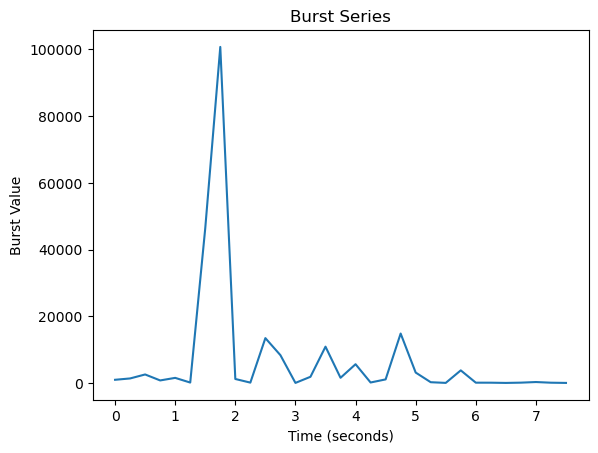

In [34]:

import matplotlib.pyplot as plt
# Plot the burst series
plt.plot(aggregated_bursts.index.total_seconds(), aggregated_bursts.values)
plt.xlabel('Time (seconds)')
plt.ylabel('Burst Value')
plt.title('Burst Series')
plt.show()
